<a href="https://colab.research.google.com/github/zzunairaa/my_nlp_notes/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LSTM**

| **Gate**                     | **Contains / Formula**               | **Activation** | **Purpose / Function**                                               |
| ---------------------------- | ------------------------------------ | -------------- | -------------------------------------------------------------------- |
|  **Forget Gate (fₜ)**      | ( fₜ = σ(W_f [hₜ₋₁, xₜ] + b_f) )     | Sigmoid (0–1)  | Controls how much of old cell memory ( Cₜ₋₁ ) to keep or discard     |
|  **Input Gate (iₜ)**       | ( iₜ = σ(W_i [hₜ₋₁, xₜ] + b_i) )     | Sigmoid (0–1)  | Controls how much of the *new candidate memory* to write into ( Cₜ ) |
|  **Candidate Memory (Ĉₜ)** | ( Ĉₜ = \tanh(W_c [hₜ₋₁, xₜ] + b_c) ) | tanh (−1 to 1) | Creates *the actual new content* that could be written into memory   |
|  **Cell State (Cₜ)**       | ( Cₜ = fₜ*Cₜ₋₁ + iₜ*Ĉₜ )             | —              | The long-term memory after combining old (kept) and new (added) info |
|  **Output Gate (oₜ)**      | ( oₜ = σ(W_o [hₜ₋₁, xₜ] + b_o) )     | Sigmoid (0–1)  | Decides what part of updated memory to output                        |
|  **Hidden State (hₜ)**     | ( hₜ = oₜ * \tanh(Cₜ) )              | tanh (−1 to 1) | The *visible output* and short-term memory for next step             |


| Role         | Symbol | Think of It As                      |
| ------------ | ------ | ----------------------------------- |
| Forget gate  | fₜ     |  “How much of the past to forget” |
| Input gate   | iₜ     |  “How much new info to write”     |
| Candidate    | Ĉₜ     |  “What the new info looks like”   |
| Cell state   | Cₜ     |  “The memory notebook”            |
| Output gate  | oₜ     |  “What to show from memory”       |
| Hidden state | hₜ     |  “What you say out loud”         |




##  Goal:

At each time step, the LSTM reads a word embedding (x_t),
updates its memory and hidden state,
and then **predicts the next word** based on (h_t).

---

#  Step-by-Step Flow for Next Word Prediction

---

### ** Step 1: Input the Current Word**

* You feed in the embedding of the current word (x_t).
* Along with it, the model receives:

  * (h_{t-1}): hidden state from the previous step
  * (C_{t-1}): cell state from the previous step

So the input to the cell is:
[
x_t, ; h_{t-1}, ; C_{t-1}
]

---

### ** Step 2: Forget Old Information**

* The **Forget Gate** decides what parts of old memory (C_{t-1}) to erase.

[
f_t = \sigma(W_f [h_{t-1}, x_t] + b_f)
]

Meaning:

* If (f_t[i] = 1): keep that piece of old memory.
* If (f_t[i] = 0): forget it completely.

---

### ** Step 3: Decide What New Info to Add**

The **Input Gate** controls *how much new info* enters the memory.

[
i_t = \sigma(W_i [h_{t-1}, x_t] + b_i)
]

Then, generate the **Candidate Memory** — what the new info *looks like*:

[
\tilde{C_t} = \tanh(W_c [h_{t-1}, x_t] + b_c)
]

 Meaning:

* Candidate = potential new info from current word
* Input gate = permission level for that info

---

### ** Step 4: Update the Memory (Cell State)**

Now, the cell combines **old** and **new** memory:

[
C_t = f_t * C_{t-1} + i_t * \tilde{C_t}
]

 Meaning:

* Keep some old knowledge (via forget gate)
* Add some new context (via input gate)

 This updated (C_t) is the **long-term memory** of the model —
carried to future steps so it can remember context over long distances.

---

### ** Step 5: Decide What to Output (Output Gate)**

The **Output Gate** decides what portion of the updated memory to reveal now.

[
o_t = \sigma(W_o [h_{t-1}, x_t] + b_o)
]

---

### ** Step 6: Compute the Hidden State**

Finally, the hidden state (short-term output) is computed:

[
h_t = o_t * \tanh(C_t)
]

 This (h_t) now contains:

* The meaning of the current context (updated by this word)
* Enough info to predict the *next* word.

---

### ** Step 7: Predict the Next Word**

The hidden state (h_t) goes into a **fully connected (linear) layer**
followed by a **softmax** to get probabilities for the next word.

[
\hat{y_t} = \text{softmax}(W_y h_t + b_y)
]

 Meaning:

* Each neuron in ( \hat{y_t} ) = probability of a specific word in the vocabulary.
* The word with the **highest probability** is the **predicted next word**.









In [1]:
import numpy as np

# ---- Helper Functions ----
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

# ---- LSTM Cell Implementation ----
class LSTMCell:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Weight matrices for gates (combined input + hidden)
        concat_size = input_size + hidden_size

        self.Wf = np.random.randn(hidden_size, concat_size) * 0.1  # Forget gate
        self.Wi = np.random.randn(hidden_size, concat_size) * 0.1  # Input gate
        self.Wc = np.random.randn(hidden_size, concat_size) * 0.1  # Candidate
        self.Wo = np.random.randn(hidden_size, concat_size) * 0.1  # Output gate

        # Biases for each gate
        self.bf = np.zeros((hidden_size, 1))
        self.bi = np.zeros((hidden_size, 1))
        self.bc = np.zeros((hidden_size, 1))
        self.bo = np.zeros((hidden_size, 1))

        # Output layer (for next word prediction)
        self.Wy = np.random.randn(output_size, hidden_size) * 0.1
        self.by = np.zeros((output_size, 1))

    def forward(self, x_t, h_prev, C_prev):
        # 1️ Concatenate input and previous hidden
        z = np.vstack((h_prev, x_t))  # shape = (hidden + input, 1)

        # 2️ Forget gate
        f_t = sigmoid(np.dot(self.Wf, z) + self.bf)

        # 3️ Input gate
        i_t = sigmoid(np.dot(self.Wi, z) + self.bi)

        # 4️ Candidate memory
        C_tilde = tanh(np.dot(self.Wc, z) + self.bc)

        # 5️ Update cell state
        C_t = f_t * C_prev + i_t * C_tilde

        # 6️ Output gate
        o_t = sigmoid(np.dot(self.Wo, z) + self.bo)

        # 7️ Hidden state
        h_t = o_t * tanh(C_t)

        # 8️ Prediction for next word (softmax output)
        y_t = np.dot(self.Wy, h_t) + self.by
        y_hat = np.exp(y_t) / np.sum(np.exp(y_t))  # softmax

        # Return all intermediate values (so we can inspect)
        return h_t, C_t, y_hat, (f_t, i_t, C_tilde, o_t)


In [3]:
# ---- Hyperparameters ----
input_size = 4   # dimension of embedding
hidden_size = 6  # number of LSTM neurons
output_size = 5  # pretend we have 5 words in vocab

# Initialize LSTM cell
lstm = LSTMCell(input_size, hidden_size, output_size)

# Initial hidden and cell states, both are empty
h_prev = np.zeros((hidden_size, 1))
C_prev = np.zeros((hidden_size, 1))

# Sample "word embeddings" for a short sequence (3 words)
np.random.seed(1)
sequence = [np.random.randn(input_size, 1) for _ in range(3)]

# ---- Forward through sequence ----
for t, x_t in enumerate(sequence, start=1):
    print(f"\n🕐 Time Step {t}")
    h_prev, C_prev, y_hat, (f_t, i_t, C_tilde, o_t) = lstm.forward(x_t, h_prev, C_prev)

    print("Forget Gate f_t:", f_t.ravel())
    print("Input Gate i_t :", i_t.ravel())
    print("Candidate Ĉ_t  :", C_tilde.ravel())
    print("Updated Cell C_t:", C_prev.ravel())
    print("Output Gate o_t:", o_t.ravel())
    print("Hidden h_t:", h_prev.ravel())
    print("Predicted Next Word Probabilities (softmax):", y_hat.ravel())



🕐 Time Step 1
Forget Gate f_t: [0.47664431 0.50078572 0.58165869 0.50092533 0.47443644 0.63895839]
Input Gate i_t : [0.50601028 0.46692361 0.43753262 0.49836757 0.56011156 0.4567921 ]
Candidate Ĉ_t  : [ 0.14709731  0.2670082   0.20290211  0.38787645  0.16215701 -0.05082497]
Updated Cell C_t: [ 0.07443275  0.12467243  0.08877629  0.19330504  0.09082602 -0.02321644]
Output Gate o_t: [0.50014805 0.4650228  0.52033628 0.46610233 0.43469101 0.60275599]
Hidden h_t: [ 0.0371588   0.057677    0.04607255  0.08899421  0.03937305 -0.01399134]
Predicted Next Word Probabilities (softmax): [0.19871997 0.19639208 0.20126966 0.20287529 0.200743  ]

🕐 Time Step 2
Forget Gate f_t: [0.39721399 0.44260715 0.49789767 0.48672764 0.39987098 0.57470505]
Input Gate i_t : [0.45208856 0.48688899 0.40386417 0.42837543 0.51196785 0.43447188]
Candidate Ĉ_t  : [ 0.03421366  0.00492324  0.25678201  0.42030974 -0.10130659  0.21713938]
Updated Cell C_t: [ 0.04503333  0.05757798  0.14790656  0.27413727 -0.01554703  0.0

In [6]:
import torch
import torch.nn as nn

class MyLSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(MyLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True) #it computes the steps we have seen manual
        self.fc = nn.Linear(hidden_dim, vocab_size) #nn.Linear(in_features=hidden_dim, out_features=vocab_size)
#nn.linear is needed for the computation of output
    def forward(self, x, h=None):
        x = self.embedding(x) #converts word indices into dense embedding vector
        out, (h, c) = self.lstm(x, h) #LSTM layer process the entire sequence
        out = self.fc(out)
        return out, (h, c)

# Example usage
vocab_size = 100
model = MyLSTMModel(vocab_size, embed_dim=10, hidden_dim=20)

# A batch with one sentence of 5 words (token IDs)
inputs = torch.randint(0, vocab_size, (1, 5))
outputs, _ = model(inputs)

print("Input IDs :", inputs)
print("Output logits shape:", outputs.shape)  # (1, 5, vocab_size)


Input IDs : tensor([[31, 60, 23, 31, 73]])
Output logits shape: torch.Size([1, 5, 100])


x is a batch of word indices integers representing words in your vocabulary.

***out, (h, c) = self.lstm(x, h)***
Here the LSTM layer processes the entire sequence.
This is where all your “forget”, “input”, and “output” gates from before actually work.

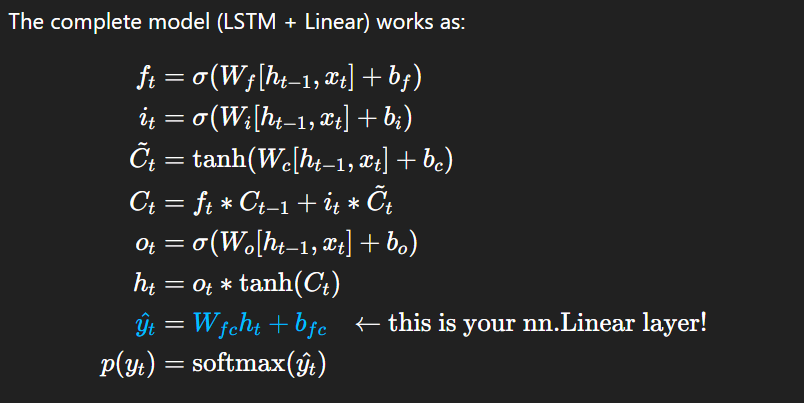

| Problem in RNN                                                                                                   | How LSTM fixes it                                                                                       |
| ---------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------- |
| **1️ Vanishing gradients** — RNNs forget long-ago words because their gradients shrink as sequences get longer. |  LSTM adds a **cell state** that carries information across many time steps, keeping gradients stable. |
| **2️ No control over what to remember or forget**                                                               |  LSTM uses **three gates** (input, forget, output) to *selectively* store or discard information.      |
| **3️ Poor at long-term dependencies** — can’t connect “If … then …” patterns far apart.                         |  LSTM can remember context over long distances — ideal for long sentences, paragraphs, or time series. |
| **4️ Easily loses context**                                                                                     | LSTM preserves relevant context with its internal memory mechanism.                                   |




###  **Limitations of LSTM :**

1️ **Slow training**  processes words one by one (can’t parallelize).

2️ **Hard to handle very long sequences**  still forgets distant information.

3️ **Computationally heavy**  many parameters (four gates).

4️ **Difficult to interpret**  we can’t easily see what it “remembers.”

5️ **Not scalable**  struggles with very large datasets compared to Transformers.



# **NEED FOR GRU**

 Every LSTM cell (at each time step) has its own hidden state .
 But they all share the same weights  they just update their states differently based on the input sequence.

 ht -> short term meory

 Ct -> long term memory



What if we merge both memories (hₜ and Cₜ) into one simpler state
and use fewer gates to make the model faster?

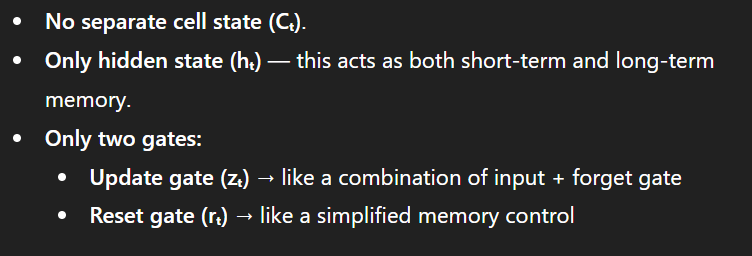

GRU is a simplified LSTM that merges long-term and short-term memory into one hidden state,
uses two gates (update & reset), and trains faster with nearly the same accuracy.



##  **Goal**

At each time step, the **GRU** reads a word embedding (x_t), updates its **hidden state** (h_t) (there’s no cell state here), and predicts the next word based on (h_t).

---

##  **Step-by-Step Flow for Next-Word Prediction**

---

### **Step 1: Input the Current Word**

You feed in the **embedding of the current word** (x_t).

Along with it, the model receives:

* (h_{t-1}): hidden state from the previous step (the memory).

So the input to the GRU cell is:
([,x_t,; h_{t-1},])

---

### **Step 2: Reset Gate — “How much of the past to forget”**

The **reset gate** decides how much of the previous hidden state to use when forming new information.

[
r_t = \sigma(W_r [h_{t-1}, x_t] + b_r)
]

**Meaning**

* (r_t[i] \approx 0): ignore that neuron’s old memory.
* (r_t[i] \approx 1): keep it fully.

So this gate controls *how much past context to reset*.

---

### **Step 3: Update Gate — “How much to keep from old vs new”**

The **update gate** decides how much of the old memory to keep versus how much to replace with new info.

[
z_t = \sigma(W_z [h_{t-1}, x_t] + b_z)
]

**Meaning**

* (z_t[i] \approx 1): rely on new information.
* (z_t[i] \approx 0): keep old memory.

---

### **Step 4: Candidate Hidden State — “New proposed information”**

Form a **candidate** hidden state (the “draft” of what new info might look like):

[
\tilde{h}*t = \tanh(W_h [r_t \odot h*{t-1}, x_t] + b_h)
]

**Meaning**

* Apply reset gate first → use filtered memory (r_t \odot h_{t-1}).
* Combine with current input (x_t).
* Pass through (\tanh) → gives possible new info for the current word.

---

### **Step 5: Update the Hidden State (Final Memory)**

Now blend the old and new information to form the **final hidden state**:

[
h_t = (1 - z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t
]

**Meaning**

* Keep some old context ((1 - z_t) part).
* Add some new understanding ((z_t \times \tilde{h}_t)).

 This **(h_t)** is both the *short-term* and *long-term* memory — GRU doesn’t have a separate cell state like LSTM.

---

### **Step 6: Predict the Next Word**

The hidden state now holds everything the model knows about the sentence so far.
Use it to predict the next word:

[
\hat{y_t} = \text{softmax}(W_y h_t + b_y)
]

**Meaning**

* Each neuron in (\hat{y_t}) = probability of a word in the vocabulary.
* The highest-probability word → model’s predicted next word.






In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ----- Step 1: Define GRU-based Model -----
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)     # Step 1: word embeddings
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True)  # Step 2: GRU layer
        self.fc = nn.Linear(hidden_dim, vocab_size)              # Step 3: map hidden -> vocab logits

    def forward(self, x, h=None):
        # x shape: (batch, seq_len)
        embedded = self.embedding(x)              # (batch, seq_len, embed_dim)
        out, h = self.gru(embedded, h)            # out: (batch, seq_len, hidden_dim)
        out = self.fc(out)                        # (batch, seq_len, vocab_size)
        return out, h


# ----- Step 2: Create Model -----
vocab_size = 100        # suppose we have 100 words in vocab
embed_dim = 10          # each word = 10-dim vector
hidden_dim = 20         # GRU hidden state size

model = GRUModel(vocab_size, embed_dim, hidden_dim)


# ----- Step 3: Input Example -----
# A batch with 1 sentence of 5 words (token IDs)
inputs = torch.randint(0, vocab_size, (1, 5))  # e.g., [[23, 11, 5, 78, 41]]

# Forward pass
outputs, hidden = model(inputs)

print("Input IDs:", inputs)
print("Output shape:", outputs.shape)  # (1, 5, vocab_size)
print("Hidden shape:", hidden.shape)   # (1, 1, hidden_dim)

# ----- Step 4: Predict Next Word (softmax for last timestep) -----
last_output = outputs[:, -1, :]         # last word's logits
probs = F.softmax(last_output, dim=-1)  # convert to probabilities
predicted = torch.argmax(probs, dim=-1)

print("Next word ID (predicted):", predicted.item())


Input IDs: tensor([[10, 27, 10, 99, 21]])
Output shape: torch.Size([1, 5, 100])
Hidden shape: torch.Size([1, 1, 20])
Next word ID (predicted): 38


|  Limitation                                                       |                                                                                                    Explanation                                               |  |
| --------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------ | ----------- |
| **1️ Less control over memory**                          | GRU merges long-term and short-term memory into one hidden state → less fine-grained control compared to LSTM’s separate cell + hidden states.               |             |
| **2️ Can forget long dependencies**                      | While better than vanilla RNN, GRU can still struggle with *very long sequences* (since it has no dedicated cell state like LSTM).                           |             |
| **3️ No clear separation between “memory” and “output”** | Because ( h_t ) acts as both the stored memory and output, it’s harder to interpret or manipulate separately (e.g., when you only want to preserve context). |             |
| **4️ Slightly less expressive for complex tasks**        | For complicated temporal or language patterns, LSTMs may perform slightly better because of the extra gating (output gate and cell state).                   |             |
| **5️ No universal dominance**                            | GRU doesn’t always outperform LSTM — results depend on dataset size, sequence length, and task complexity.                                                   |             |
| **6️ Still sequential & slow for long inputs**           | Like LSTM, GRU processes one time step at a time → cannot parallelize well across long sequences (Transformers solve this).                                  |             |


# **xLSTM**

The xLSTM introduces three main upgrades over classical LSTM:

1️.  Exponential Gating Functions instead of sigmoids

2️.  Stabilizer States to prevent exponential overflow

3️ Matrix based Memory Cells that allows parallel updates(optional) (mLSTM)



sLSTM → scalar extended LSTM (normal memory)

mLSTM → matrix extended LSTM (multi-memory / multi-head)



### Step-by-Step: sLSTM (Scalar xLSTM)


A normal LSTM performs the following steps:
Forget → Input → Update Cell → Output.

The xLSTM still does this but it changes how each gate is computed and controlled.

---

#### Step 1: Inputs

At each time step `t`:

```
x_t = current input (embedding)
h_{t-1} = previous hidden state
c_{t-1} = previous cell state
```

The cell processes these to produce new states:

```
h_t, c_t
```

---

#### Step 2: Compute the Raw Gates

Each gate has a raw (pre-activation) value:

```
f_t_tilde = W_f [h_{t-1}, x_t] + b_f
i_t_tilde = W_i [h_{t-1}, x_t] + b_i
o_t_tilde = W_o [h_{t-1}, x_t] + b_o
```

In a standard LSTM, we apply a sigmoid activation.
In xLSTM, we replace the sigmoid with an **exponential gating function**.

---

#### Step 3: Exponential Gating with Stabilizers

The exponential gates are defined as:

```
f_t = max(0, 1 - exp(-f_t_tilde + s_t_f))
i_t = max(0, 1 - exp(-i_t_tilde + s_t_i))
```

where `s_t_f` and `s_t_i` are **stabilizer states** (small learned parameters).
They prevent exponential overflow and adjust sensitivity dynamically.

**Intuition:**

* `f_t` decides how much old memory to erase.
* `i_t` decides how much new information to add.

Instead of a 0–1 squashing (sigmoid), exponentials allow smoother and stronger scaling.

---

#### Step 4: Compute the Candidate Memory

```
c_t_tilde = tanh(W_c [h_{t-1}, x_t] + b_c)
```

This represents the **new candidate information** to add into memory.

---

#### Step 5: Update the Memory (Cell State)

```
c_t = f_t * c_{t-1} + i_t * c_t_tilde
```

Here both `f_t` and `i_t` are exponential gates, which control how much of the old memory is retained and how much new information is written.
This design enables stronger gradient flow and more flexible memory mixing.

---

#### Step 6: Compute the Output Gate

```
o_t = max(0, 1 - exp(-o_t_tilde))
```

This gate determines how much of the current cell state will influence the output.

---

#### Step 7: Compute the Hidden State

```
h_t = o_t * tanh(c_t)
```

The hidden state `h_t` is derived from the updated cell state `c_t`.
It carries short-term context to the next time step and can be used for predictions.






### Step-by-Step: mLSTM (Matrix xLSTM)

A normal LSTM performs the following sequence:
Forget → Input → Update Cell → Output.

The mLSTM keeps the same logic but extends memory from a single vector to a **matrix**, allowing multiple parallel memory “heads” and exponential gating instead of sigmoid.

---

#### Step 1: Inputs and Memory State

At each time step `t`:

```
x_t = current input (embedding vector)
h_{t-1} = previous hidden state (matrix form)
C_{t-1} = previous memory matrix (n × k)
```

The mLSTM cell produces updated states:

```
h_t, C_t
```

Here, `n` is the number of neurons and `k` is the number of memory heads (parallel sub-memory streams).

---

#### Step 2: Combine Input and Hidden State

Concatenate the input and previous hidden state:

```
z_t = [x_t, h_{t-1}]
```

This combined vector `z_t` represents everything the model knows up to the current time step.

---

#### Step 3: Compute Exponential Gates

In a standard LSTM, the gates (forget, input, output) are 1D vectors.
In mLSTM, they are extended to 2D matrices:

```
F_t, I_t, O_t ∈ R^(n × k)
```

Each **column** represents one memory head.
Each **row** represents a neuron’s activation across those heads.

Gate computation:

```
F_t = exp(W_f z_t)
I_t = exp(W_i z_t)
O_t = exp(W_o z_t)
```

Each gate now uses **exponential activation** instead of sigmoid.
This means they scale more smoothly, respond faster, and avoid saturation.

**Why exponential gates are used:**

* They provide smoother gradients during training.
* They allow stronger and more flexible memory control.
* They prevent early saturation, which is a limitation of sigmoid and tanh.

---

#### Step 4: Compute the Candidate Memory

The candidate memory stores new information to be written into the memory matrix:

```
C_t_tilde = tanh(W_c [h_{t-1}, x_t] + b_c)
```

This produces a matrix of the same shape as the memory `C_{t-1}`:

```
C_t_tilde ∈ R^(n × k)
```

---

#### Step 5: Update the Memory Matrix

The memory update rule is defined as:

```
C_t = F_t * C_{t-1} + I_t * C_t_tilde
```

Here:

* `F_t` controls how much of the old memory is kept.
* `I_t` controls how much of the new candidate memory is added.
* The multiplication `*` is element-wise across the entire matrix.

**Why this step is powerful:**

* In a normal LSTM, only one memory vector is updated per step.
* In mLSTM, multiple memory heads (columns) are updated in parallel.
* Each head learns to capture a different type of information (for example: syntax, semantics, or long-term dependencies).

---

#### Step 6: Compute the Output Gate

```
O_t = exp(W_o [h_{t-1}, x_t] + b_o)
```

The output gate decides how much of the memory matrix `C_t` should be exposed to the hidden state.

---

#### Step 7: Compute the Hidden State

Combine the output gate with the updated memory to generate the new hidden matrix:

```
H_t = O_t * tanh(C_t)
```

`H_t` is a matrix of size `(n × k)`, where:

* Each column represents one memory head’s contribution.
* Each row represents a neuron’s activation strength across those heads.

To produce a final hidden vector for downstream layers (like a classifier or decoder), aggregate the matrix across heads:

```
h_t = Aggregate(H_t)
```

Common aggregation methods:

* **Mean pooling:** average across all heads
* **Sum pooling:** sum across all heads
* **Concatenation:** flatten `H_t` into a single long vector

---

#### Step 8: Compute the Model Output (Prediction)

Once we have the final hidden vector `h_t`, we compute the model’s external output (for example, next-word prediction):

```
y_hat_t = softmax(W_y h_t + b_y)
```

Where:

* `W_y ∈ R^(|V| × n)` maps the hidden state to the vocabulary space
* `|V|` is the vocabulary size or number of output classes
* `b_y` is a bias term
* `y_hat_t ∈ R^(|V|)` is the probability distribution over all possible next tokens or classes

The softmax layer converts the raw logits into probabilities that sum to 1.
The token with the highest probability is selected as the predicted next word or class.

---

#### Why mLSTM Works Well

* Multi-head memory learns multiple sequence patterns at once.
* Exponential gates provide stronger and smoother gradient flow.
* Matrix-based memory enables natural parallelization and faster training.
* Eliminates sequential bottlenecks, allowing scalability similar to Transformers.




In [8]:
# -------------------------------------------------------------
# Implementation of sLSTM (Scalar xLSTM) and mLSTM (Matrix xLSTM)
# -------------------------------------------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(42)

# =============================================================
# 1. Scalar xLSTM (sLSTM)
# =============================================================

class sLSTMCell(nn.Module):
    """Implements one sLSTM cell with exponential gates."""
    def __init__(self, input_size, hidden_size):
        super(sLSTMCell, self).__init__()
        self.hidden_size = hidden_size
        self.W_f = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_i = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_c = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_o = nn.Linear(input_size + hidden_size, hidden_size)

        # Stabilizer parameters (learnable scalars)
        self.s_f = nn.Parameter(torch.zeros(hidden_size))
        self.s_i = nn.Parameter(torch.zeros(hidden_size))

    def forward(self, x_t, h_prev, c_prev):
        # Combine input and previous hidden state
        z = torch.cat([x_t, h_prev], dim=1)

        # Exponential gates with stabilizers
        f_t = torch.relu(1 - torch.exp(-self.W_f(z) + self.s_f))
        i_t = torch.relu(1 - torch.exp(-self.W_i(z) + self.s_i))
        o_t = torch.relu(1 - torch.exp(-self.W_o(z)))

        # Candidate memory
        c_t_tilde = torch.tanh(self.W_c(z))

        # Memory update
        c_t = f_t * c_prev + i_t * c_t_tilde

        # Hidden state
        h_t = o_t * torch.tanh(c_t)
        return h_t, c_t


class sLSTM(nn.Module):
    """Full sLSTM network for sequence processing."""
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(sLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.cell = sLSTMCell(embed_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        batch_size, seq_len = x.shape
        h_t = torch.zeros(batch_size, self.cell.hidden_size)
        c_t = torch.zeros(batch_size, self.cell.hidden_size)

        embeds = self.embedding(x)
        for t in range(seq_len):
            h_t, c_t = self.cell(embeds[:, t, :], h_t, c_t)

        logits = self.fc(h_t)
        y_hat = F.softmax(logits, dim=1)
        return y_hat


# =============================================================
# 2. Matrix xLSTM (mLSTM) — Multi-Head Variant
# =============================================================

class mLSTM(nn.Module):
    """Simplified multi-head xLSTM approximation."""
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_heads, output_dim):
        super(mLSTM, self).__init__()
        self.num_heads = num_heads
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm_heads = nn.ModuleList([
            nn.LSTM(embed_dim, hidden_dim, batch_first=True)
            for _ in range(num_heads)
        ])

        # Aggregation layer (like Aggregate(H_t))
        self.aggregate = nn.Linear(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embeds = self.embedding(x)
        head_outputs = []

        # Each head acts as a parallel memory stream
        for lstm in self.lstm_heads:
            out, _ = lstm(embeds)
            head_outputs.append(out[:, -1])  # last time step

        # Stack and aggregate across heads
        H_t = torch.stack(head_outputs, dim=2)  # (batch, hidden_dim, num_heads)
        h_t = H_t.mean(dim=2)                   # Aggregate(H_t): mean pooling

        # Nonlinear transform (approximates exponential gating)
        h_t = torch.tanh(self.aggregate(h_t))

        logits = self.fc(h_t)
        y_hat = F.softmax(logits, dim=1)
        return y_hat


# =============================================================
# 3. Example Run (both models)
# =============================================================

vocab_size = 1000
embed_dim = 32
hidden_dim = 64
num_heads = 4
output_dim = vocab_size

# Inputs: one sentence of 10 tokens
x = torch.randint(0, vocab_size, (1, 10))

# ---- Scalar xLSTM ----
scalar_model = sLSTM(vocab_size, embed_dim, hidden_dim, output_dim)
y_scalar = scalar_model(x)

print("Scalar xLSTM:")
print("Input IDs:", x)
print("Output shape:", y_scalar.shape)
print("Predicted probs (first 5):", y_scalar[0][:5])

# ---- Matrix xLSTM ----
matrix_model = mLSTM(vocab_size, embed_dim, hidden_dim, num_heads, output_dim)
y_matrix = matrix_model(x)

print("\nMatrix xLSTM:")
print("Input IDs:", x)
print("Output shape:", y_matrix.shape)
print("Predicted probs (first 5):", y_matrix[0][:5])


Scalar xLSTM:
Input IDs: tensor([[542,  67, 876, 414,  26, 335, 620, 924, 950, 113]])
Output shape: torch.Size([1, 1000])
Predicted probs (first 5): tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0011], grad_fn=<SliceBackward0>)

Matrix xLSTM:
Input IDs: tensor([[542,  67, 876, 414,  26, 335, 620, 924, 950, 113]])
Output shape: torch.Size([1, 1000])
Predicted probs (first 5): tensor([0.0010, 0.0008, 0.0010, 0.0010, 0.0009], grad_fn=<SliceBackward0>)
